## Laden der Text Daten 

In [1]:
import os, gzip
import pandas as pd
import numpy as np
import urllib.request

DATADIR = "data"

if not os.path.exists(DATADIR): 
    os.mkdir(DATADIR)

file_name = os.path.join(DATADIR, 'bundestags_parlamentsprotokolle.csv.gzip')
if not os.path.exists(file_name):
    url_data = 'https://www.dropbox.com/s/1nlbfehnrwwa2zj/bundestags_parlamentsprotokolle.csv.gzip?dl=1'
    urllib.request.urlretrieve(url_data, file_name)

df = pd.read_csv(gzip.open(file_name)).sample(frac=1)

alle_sprecher = df.sprecher.unique()
parteien = df.partei.unique()
partei_farben = {'cducsu':'black', 'linke':'purple', 'spd':'red', 'gruene':'green', 'fdp':'yellow'}

print("{} Reden wurden geladen".format(len(df)))

# Zeige einige Reden von Parteien
for party in np.unique(df['partei']):
    print("\n****************************\nBeispiele von Partei {}:\n****************************\n".format(party))
    for _, speech in df[df['partei']==party].sample(2).iterrows():
        print("\n*******************************\nSprecher {}:\n\n{}".format(speech['sprecher'], speech['text']))


43679 Reden wurden geladen

****************************
Beispiele von Partei cducsu:
****************************


*******************************
Sprecher Dr. Stefan Kaufmann:

Bezüglich der Fusionsforschung stehen wir in dieser Woche an einem Scheideweg. Ich möchte nicht falsch verstanden werden: Selbstverständlich bekennen wir uns nach wie vor zur Fusionsforschung, weil wir die darin liegenden immensen Chancen zur Sicherung unserer Energieversorgung über das Jahr 2050 hinaus sehen. Funktioniert die Kernfusion wie geplant, können wir unseren Energiebedarf ab der zweiten Hälfte des Jahrhunderts einfach und sauber decken. Bis dahin ist es jedoch ein weiter Weg. Dieser Weg darf für die Beteiligten nicht zu einem Drahtseilakt werden, zumal uns ein Auffangnetz derzeit fehlt.

Auf die Chancen für die Hightechindustrie in Deutschland und die positiven Wechselwirkungen von ITER und der Fusionsforschung in Garching und Greifswald habe ich in meiner letzten Rede bereits hingewiesen. Nochmals

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import warnings

def train(texts, party):
    '''
    Eine Funktion, die gegeben Texte und Labels einen Klassifier trainiert
    '''
    stopwords = [w.strip() for w in open("data/stopwords.txt").readlines()]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Eine Machine Learning Pipeline um Bag-of-Words Vectors zu erstellen aus Texten
        text_clf = Pipeline([('vect', TfidfVectorizer(stop_words=stopwords)),
                            ('clf', SGDClassifier(loss='log', class_weight='balanced'))])
        # some hyperparameters
        parameters = {
            'vect__ngram_range': [(1, 1), (1, 2)],
            'vect__max_df': [0.8],
            'clf__alpha': (np.logspace(-6, -4, 2)).tolist()
        }
        # perform gridsearch to get the best regularizer
        clf = GridSearchCV(text_clf, parameters, cv=2, n_jobs=-1,verbose=4)
        clf.fit(texts, party)

    return clf


## Trainieren eines linearen Klassifiers

In [3]:
# Erst nehmen wir einige Daten beiseite, um das Model darauf spaeter testen zu koennen
train_data, test_data, train_labels, test_labels = train_test_split(df['text'], df['partei'], test_size=0.5)

# Jetzt trainieren wir den Klassifier
clf = train(train_data, train_labels)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1) ....
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1) ....
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 2) ....
[CV] clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 2) ....
[CV]  clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.4829228092665507, total=  11.0s
[CV]  clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.4817732185381938, total=  11.1s
[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1) ...
[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1) ...
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.4962915483930043, total=  13.3s
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 1), score=0.49844293826708186, total=  13.0s
[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2) ...


[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   37.8s remaining:   37.8s


[CV] clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2) ...
[CV]  clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 2), score=0.5069132863290907, total=  29.0s
[CV]  clf__alpha=1e-06, vect__max_df=0.8, vect__ngram_range=(1, 2), score=0.5043048177321854, total=  28.9s
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2), score=0.494643347678784, total=  17.9s
[CV]  clf__alpha=0.0001, vect__max_df=0.8, vect__ngram_range=(1, 2), score=0.49267265066862065, total=  17.4s


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.0min finished


# Vorhersage auf Trainings Daten

In [4]:
train_predictions = clf.predict(train_data)
report = classification_report(train_predictions, train_labels)
print(report)

             precision    recall  f1-score   support

     cducsu       1.00      1.00      1.00      7985
        fdp       1.00      1.00      1.00      1694
     gruene       1.00      1.00      1.00      3148
      linke       1.00      1.00      1.00      3055
        spd       1.00      1.00      1.00      5957

avg / total       1.00      1.00      1.00     21839



# Vorhersage auf Test Daten

In [5]:
test_predictions = clf.predict(test_data)
report = classification_report(test_predictions, test_labels)
print(report)

             precision    recall  f1-score   support

     cducsu       0.81      0.58      0.68     11189
        fdp       0.21      0.48      0.29       716
     gruene       0.27      0.53      0.36      1554
      linke       0.47      0.60      0.53      2403
        spd       0.49      0.49      0.49      5978

avg / total       0.63      0.55      0.57     21840



## Confusion Matrix

In [6]:
print(confusion_matrix(test_labels, test_predictions))

[[6500  176  148  176 1051]
 [ 944  344   49   54  285]
 [ 846   54  830  401  989]
 [ 575   35  267 1444  724]
 [2324  107  260  328 2929]]


# Bist du besser als das ML Modell? 

In [19]:
# Wir ziehen 5 zufaellige Beispiele
samples = df[df.text.apply(len) < 2000].sample(5)
vorhersage_mensch = []
vorhersage_maschine = clf.predict(samples.text)
tatsaechliche_partei = samples.partei.tolist()

for idx, text in enumerate(samples.text):
    print("================================")
    print(text)
    print('------------------------------------')
    print("Von welcher Partei ist dieser Text? Wähle aus {}".format(clf.classes_))
    vorhersage_mensch.append(input())
    print("*****************************")
    print("Deine Vorhersage: {}".format(vorhersage_mensch[-1]))
    print("ML Vorhersage: {}".format(vorhersage_maschine[idx]))
    print("Tatsächliche Partei: {}".format(tatsaechliche_partei[idx]))
    print("================================")
    
print("Deine Vorhersage Metriken:")
print(classification_report(vorhersage_mensch, tatsaechliche_partei))

print("Die Vorhersage Metriken des ML Modells:")
print(classification_report(vorhersage_maschine, tatsaechliche_partei))

Durch die Richtlinie werden nun die Einlagensicherungssysteme EU-weit harmonisiert, und es wird ein -einheitliches Schutzniveau für alle Sparer in der EU -geschaffen. Gut ausgestattete und funktionierende Einlagensicherungssysteme sind ein wesentlicher Faktor, um das Vertrauen in das Bankensystem zu stärken. Auch in der jüngeren Vergangenheit konnten wir in europäischen Ländern einen guten Eindruck davon gewinnen, was passiert, wenn Vertrauen in die finanzielle Leistungs-fähigkeit von Banken abhandenkommt.

Die Einlagensicherung vermeidet im Krisenfall einen massiven Abzug von Spareinlagen und trägt somit dazu bei, dass sich eine Krise nicht weiter verschärft.

In Deutschland haben wir schon lange ein sehr gutes System der Einlagensicherung. Die Entschädigungseinrichtungen der privaten und öffentlichen Banken, die -institutsbezogenen Sicherungssysteme der regionalen Sparkassen- und Giroverbände und die Sicherungs-einrichtung des Bundesverbandes der Deutschen Volksbanken und Raiffeisenb

## Download eines Zeitungsartikels

In [13]:
import urllib.request
from readability.readability import Document

url = "http://www.spiegel.de/politik/ausland/muss-deutschland-jetzt-milliarden-an-polen-zahlen-a-1167144.html"
html = urllib.request.urlopen(url).read()
readable_article = Document(html).summary()
readable_title = Document(html).short_title()


## Klassifizierung des Zeitungsartikels

Zeitungsartikel: Muss Deutschland jetzt Milliarden an Polen zahlen?


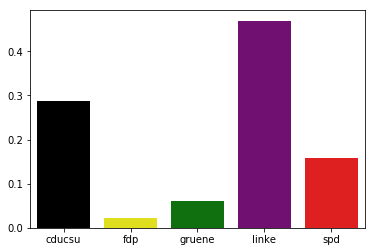

In [14]:
prediction = clf.predict_proba([readable_article])

print("Zeitungsartikel: {}".format(readable_title))

import seaborn as sns
%matplotlib inline
sns.barplot(clf.best_estimator_.steps[1][1].classes_, prediction.flatten(), palette=[partei_farben[p] for p in clf.classes_])

In [15]:
bow_vectors = clf.best_estimator_.steps[0][1].transform(df.text)
idx2words = {k:v for v,k in clf.best_estimator_.steps[0][1].vocabulary_.items()}
for party in np.unique(df['partei']):
    this_party = (df['partei'] == party).values * 2 - 1
    word_covariance = bow_vectors.T.dot(this_party).argsort()
    top_words = [idx2words[widx] for widx in word_covariance[-20:][::-1]]
    print("*********************\nPartei {} benutzt haeufig:\n{}".format(party, ", ".join(top_words)))

*********************
Partei cducsu benutzt haeufig:
christlich, wettbewerbsfähigkeit, liberale koalition, christlich liberale, kernenergie, christlich liberalen, asylbewerber, christen, liberalen koalition, flüchtlingskrise, ukraine, wolfgang schäuble, richtigen, dankeschön, währung, stabilität, eigenverantwortung, ausgeglichenen, vernetzten, russlands
*********************
Partei fdp benutzt haeufig:
fdp bundestagsfraktion, fdp fraktion, liberaler, sicht fdp, freien demokraten, sharma, bafög modernisierung, liberaler sicht, waffensteuer, zuwanderungssteuerung, unimog, verbrechen deutschen, hefen, lehnt fdp, schuldenbergen kinder, frühen bundesrepublik, verwaltungsmodernisierung, banken restrukturierungsgesetz, justice gesetz, beschaffungsmaßnahmen
*********************
Partei gruene benutzt haeufig:
garantierente, klimakrise, tisa, staaten regelung, leiharbeitskräfte, finanzaufsichtsbehörde, wehrbericht, dualplus, adoptionsmöglichkeiten, bankschulden, immigranten, mindestniveau, schu

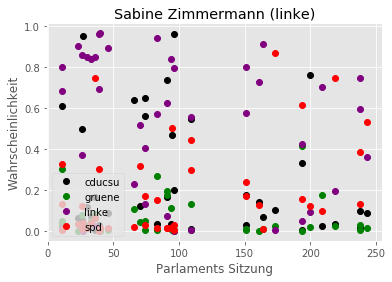

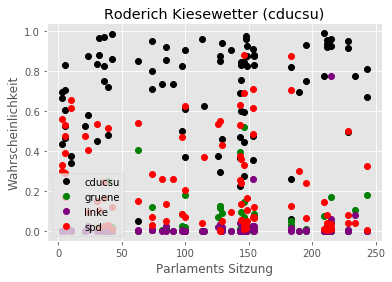

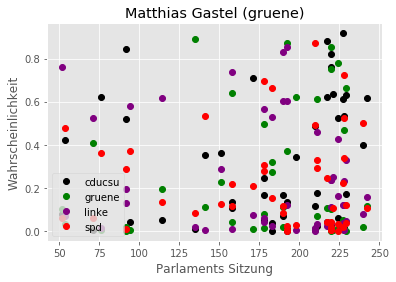

In [21]:
import matplotlib
matplotlib.style.use('ggplot')
import pylab as plt

# Wir betrachten nur die letzte Legislaturperiode
wahlperiode = 18
savepath = os.path.join(DATADIR,'sprecher-timeseries-{}'.format(wahlperiode))
if not os.path.exists(savepath): 
    os.mkdir(savepath)

# for sprecher in alle_sprecher:
for sprecher in ['Sabine Zimmermann', 'Roderich Kiesewetter', 'Matthias Gastel']:

    traindf = df[(df['sprecher']!=sprecher) & (df['wahlperiode']==wahlperiode)]
    testdf = df[(df['sprecher']==sprecher) & (df['wahlperiode']==wahlperiode)].sort_values(['sitzung'])

    if (len(traindf) > 10) and (len(testdf) > 10):
        partei = testdf.partei.values[0]
        tmpclf = clf.best_estimator_.fit(traindf.text, traindf.partei)
        predictions = tmpclf.predict_proba(testdf.text)
        plt.figure()
        for partei_idx in range(predictions.shape[-1]):
            color = partei_farben[tmpclf.classes_[partei_idx]]
            plt.plot(testdf.sitzung, predictions[:, partei_idx],"o",color=color)
            plt.title("{} ({})".format(sprecher,partei))
            plt.savefig(os.path.join(savepath, sprecher + ".pdf"))
            plt.xlabel('Parlaments Sitzung')
            plt.ylabel('Wahrscheinlichkeit')
            plt.legend(tmpclf.classes_, loc='lower left')
